# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [49]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from scipy.sparse import csr_matrix
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data=sorted_data.sort_values('Time')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()
y = final['Score']

(87773, 10)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love Pretzels and have to say that after trying my way through many different kinds, these are The BEST.<br /><br />The taste great, are REALLY crunchy - a key requirement for me - and have just the right amount of salt. The Newman is Rounds are just as good - maybe even better.<br /><br />And as an added bonus, Paul Newmann donates all his after tax profits from the sale of his products to charity - an unbeatable combination in my book!


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love Pretzels and have to say that after trying my way through many different kinds these are The BEST br br The taste great are REALLY crunchy a key requirement for me and have just the right amount of salt The Newman is Rounds are just as good maybe even better br br And as an added bonus Paul Newmann donates all his after tax profits from the sale of his products to charity an unbeatable combination in my book 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
final['CleanedText'] = preprocessed_reviews

100%|██████████| 87773/87773 [00:52<00:00, 1673.05it/s]


In [25]:
preprocessed_reviews[1500]

'love pretzels say trying way many different kinds best taste great really crunchy key requirement right amount salt newman rounds good maybe even better added bonus paul newmann donates tax profits sale products charity unbeatable combination book'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [90]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [27]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [153]:
# Word2Vec model for train/test and cv dataset
i=0
list_of_sent=[]
for sent in X_train['CleanedText'].values:
    list_of_sent.append(sent.split())
print(X_tr['CleanedText'].values[0])
    
print("*****************************************************************")
print(list_of_sent[0])

# Word2Vec model for test
i=0
list_of_sent_test=[]
for sent in X_test['CleanedText'].values:
    list_of_sent_test.append(sent.split())
print(X_test['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

# Word2Vec model for CV
i=0
list_of_sent_cv=[]
for sent in X_cv['CleanedText'].values:
    list_of_sent_cv.append(sent.split())
print(X_test['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_cv[0])

w2v_model_train=Word2Vec(list_of_sent,min_count=5,size=50, workers=5)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=5)
w2v_words = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


different opinion first reviewer think triple berry granola simply great tasty full whole grain goodness may need berries though sometimes get bag no berries try see like way full fiber good
*****************************************************************
['excited', 'gum', 'not', 'artificial', 'sweeteners', 'bought', 'two', 'boxes', 'glee', 'gum', 'peppermint', 'triple', 'berry', 'arrived', 'tore', 'open', 'box', 'popped', 'pieces', 'disappointment', 'began', 'minutes', 'later', 'flavor', 'quickly', 'dissipated', 'took', 'couple', 'pieces', 'flavor', 'returned', 'disappointed', 'later', 'went', 'away', 'money', 'better', 'spent', 'sucking', 'lollipops', 'eating', 'found', 'gum', 'not', 'artificial', 'sweeteners', 'dentine', 'gum', 'cinnamon', 'never', 'ending', 'disappointment', 'never', 'ending', 'calories', 'try', 'keep', 'flavor']
disappointed gerber added dha green beans son used love gerber organic green beans unwittingly tried feeding new formulation added dha kept refusing not

In [125]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8497572541236877), ('awesome', 0.8415793180465698), ('good', 0.8220787644386292), ('terrific', 0.8089662194252014), ('excellent', 0.793988823890686), ('wonderful', 0.7904127836227417), ('perfect', 0.7855398654937744), ('amazing', 0.7499324083328247), ('nice', 0.712704598903656), ('fabulous', 0.6920047402381897)]
[('greatest', 0.8216128945350647), ('best', 0.7184992432594299), ('nastiest', 0.7126660346984863), ('tastiest', 0.7060397267341614), ('coolest', 0.6580905914306641), ('closest', 0.6341551542282104), ('disgusting', 0.618719756603241), ('experienced', 0.6100812554359436), ('horrible', 0.598488450050354), ('cry', 0.5878204107284546)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


In [129]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))



sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))




100%|██████████| 70218/70218 [02:29<00:00, 469.41it/s]


70218
50


100%|██████████| 17555/17555 [00:38<00:00, 461.20it/s]


17555
50


In [154]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 14044/14044 [00:33<00:00, 420.09it/s]


14044
50


#### [4.4.1.2] TFIDF weighted W2v

In [130]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [131]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 17555/17555 [13:54<00:00, 21.03it/s]


In [155]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 14044/14044 [10:15<00:00, 22.83it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

##Splitting into train and test dataset

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

#X_train, X_test= np.split(final, [int(0.80 *len(final))])
X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.2)
#y_train = X_train['Score']
#y_test = X_test['Score']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#Splitting train data into train and cv(60:20)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)


(70218, 11) (70218,)
(17555, 11) (17555,)
(56174, 11) (56174,)
(14044, 11) (14044,)


In [72]:
#Applying BoW
count_vect = CountVectorizer()
count_vect.fit(X_train['CleanedText'])
train_bow = count_vect.transform(X_train['CleanedText'])
cv_bow = count_vect.transform(X_cv['CleanedText'])
test_bow = count_vect.transform(X_test['CleanedText'])
print(test_bow.shape)
print(cv_bow.shape)
print(train_bow.shape)

(17555, 49248)
(70218, 49248)


## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [73]:
#https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
#Applying GridSearch to find the best hyperparameter C

tuned_parameter = [{'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]}]
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
grid = GridSearchCV(estimator=clf, param_grid = tuned_parameter ,scoring = scoring, refit = 'AUC')
grid.fit(train_bow, y_tr)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.score(cv_bow,y_cv))
results = grid.cv_results_
#print(results)
#print(grid.confusion_matrix)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000,
                                10000]}],
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, verbose=0)
0.9319211115814207
LogisticRegression(C=1, class_weight=None, dua

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

Sparsity: 5078
Area under the ROC curve : %f 0.9343374886420559
[[ 1892   935]
 [  485 14243]]


Text(0.5, 15.0, 'Predicted label')

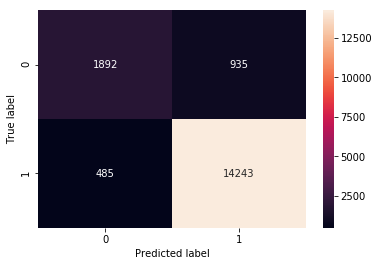

In [75]:
# Please write all the code with proper documentation

clf = LogisticRegression(C=1, penalty ='l1');
clf.fit(train_bow, y_tr)
w = clf.coef_
print("Sparsity:",np.count_nonzero(w))

#conf_matrix = confusion_matrix(y_test,pred)
cclf=clf.predict(cv_bow)
pred_cv = clf.predict_proba(cv_bow)[:,1]
#print('alpha value = ',1)
#acc = accuracy_score(y_test,pred_test)*100
#print("Accuracy",acc)
fpr, tpr, thresholds = roc_curve(y_cv,pred_cv)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_cv, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')



#clf = LogisticRegression(C=0.1, penalty ='l1');
#clf.fit(train_bow, y_tr)
#w = clf.coef_
#print(np.count_nonzero(w))


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Sparsity with L2 regularization: 5078
Area under the ROC curve : %f 0.9348129899719608
[[ 1920   907]
 [  477 14251]]


Text(0.5, 15.0, 'Predicted label')

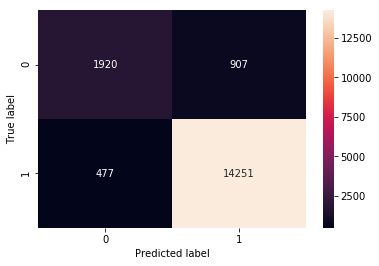

In [77]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation

clf_l2 = LogisticRegression(C=1, penalty ='l2');
clf_l2.fit(train_bow, y_train)
w = clf.coef_
print("Sparsity with L2 regularization:",np.count_nonzero(w))
#acc = accuracy_score(y_test,pred)*100
#print("Accuracy",acc)
#conf_matrix = confusion_matrix(y_test,pred)
cclf_l2=clf_l2.predict(test_bow)
pred_cv_l2 = clf_l2.predict_proba(test_bow)[:,1]
#print('alpha value = ',1)
fpr, tpr, thresholds = roc_curve(y_test,pred_cv_l2)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf_l2)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')



#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [107]:
W=clf_l2.coef_

train_bow_noise=train_bow

train_bow_noise.data=train_bow_noise.data+np.random.normal(loc=0,scale=0.0001,size=train_bow_noise.data.shape)

print(train_bow_noise.shape)

clf_noise=LogisticRegression(penalty='l2',C=1)
clf_noise.fit(train_bow_noise,y_train)
W_noise=clf_noise.coef_

#to eliminate divisible by zero error we will add 10^-6 to W_before and W_after
W+=10**-6
W_noise+=10**-6

per_vector=[]

for i in range(len(W[0])):
    val=W_noise[0][i]-W[0][i]
    val/=W[0][i]
    per_vector.append(val)
    
original_per_vect=np.absolute(per_vector)    
per_vector=sorted(np.absolute(per_vector))[::-1]

#percentage change in vectors

per_vector[ :10]

(70218, 49248)


[276.9429848259032,
 35.80250447935024,
 29.699821926067347,
 26.50412759822302,
 26.501565643398038,
 26.49754425146984,
 26.49227228567818,
 18.938156691395275,
 18.93427103811104,
 18.934193635191296]

In [108]:
for i in range(11):
    print(str(i*10)+'th percentile = '+str(np.percentile(per_vector,i*10)))
    
#for i in np.arange(0,100):
    #p = np.percentile(per_vector , i)
    #print('Value of %s th percentile is %s' %(i, p))


0th percentile = 1.6889636274931553e-08
10th percentile = 7.657816740266077e-05
20th percentile = 0.00016293914614321818
30th percentile = 0.0002641452251113123
40th percentile = 0.0003961489148487029
50th percentile = 0.0005898973478070326
60th percentile = 0.0009344673338713899
70th percentile = 0.0017860118331911835
80th percentile = 0.006215138567316911
90th percentile = 0.09536132518555572
100th percentile = 276.9429848259032


In [109]:
for i in range(90,101):
    print(str(i)+'th percentile ='+str(np.percentile(per_vector,i)))

90th percentile =0.09536132518555572
91th percentile =0.1570719869362489
92th percentile =0.2278717935051126
93th percentile =0.3346758141782121
94th percentile =0.45225358014897155
95th percentile =0.5796883474034835
96th percentile =0.6768240085194605
97th percentile =0.7271148537481824
98th percentile =0.7577408457721213
99th percentile =0.816856331646355
100th percentile =276.9429848259032


In [110]:
for i in range(1,11):
    print(str(99+(10**-1)*i)+'th percentile ='+str(np.percentile(per_vector,99+(10**-1)*i)))

99.1th percentile =0.8302463755514311
99.2th percentile =0.8640795314244532
99.3th percentile =0.8906013581577406
99.4th percentile =0.9102215647866798
99.5th percentile =0.9220621526386695
99.6th percentile =0.9679272621154136
99.7th percentile =1.2119939489930571
99.8th percentile =1.5527449780794678
99.9th percentile =2.3096668258001616
100.0th percentile =276.9429848259032


In [156]:
print('Features from 99.9th percentile to 100th percentile')
#original_per_vect=original_per_vect.tolist()
original_per_vect=[]
all_features = count_vect.get_feature_names()
for i in range(1,11):
    indx=original_per_vect.index(np.percentile(per_vector,99.9+(10**-2)*i))
    print(all_features[indx])
indx=original_per_vect.index(indx)

#print(all_features[indx])

Features from 99.9th percentile to 100th percentile


ValueError: 2.311651975343302 is not in list

In [ ]:
#Trying different C values to predict Sparsity

In [116]:
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(train_bow, y_train)

pred = clf.predict(test_bow)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)
print("Sparsity with C = 100:", s1)

clf = LogisticRegression(C=10, penalty='l1')
clf.fit(train_bow, y_train)

pred = clf.predict(test_bow)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)
print("Sparsity with C = 10:", s1)

clf = LogisticRegression(C=1, penalty='l1')
clf.fit(train_bow, y_train)

pred = clf.predict(test_bow)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)
print("Sparsity with C = 1:", s1)


clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(train_bow, y_train)

pred = clf.predict(test_bow)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)
print("Sparsity with C = 0.1:", s1)


clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(train_bow, y_train)

pred = clf.predict(test_bow)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)
print("Sparsity with C = 0.01:", s1)

Sparsity with C = 100: 12884
Sparsity with C = 10: 10758
Sparsity with C = 1: 5075
Sparsity with C = 0.1: 984
Sparsity with C = 0.01: 145



From above results, it is found that as the C value decreases, sparsity also decreases.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [103]:
# Please write all the code with proper documentation

weight=clf_l2.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])



Top 10 positive features :
pleasantly
worried
satisfied
beat
excellent
welcome
delicious
amazing
hooked
complaint


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [104]:
# Please write all the code with proper documentation
print('Top 10 negative features :')
for i in list(neg_indx[0][:10]):
    print(all_features[i])

Top 10 negative features :
worst
cancelled
disappointing
undrinkable
terrible
rip
tasteless
sounded
disappointment
flavorless


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [119]:
# Please write all the code with proper documentation
tfidf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
tfidf_vect.fit(X_train['CleanedText'])
train_tfidf = tfidf_vect.transform(X_train['CleanedText'])
#cv_bow = count_vect.transform(X_cv['CleanedText'])
test_tfidf = tfidf_vect.transform(X_test['CleanedText'])
print(test_tfidf.shape)
#print(cv_bow.shape)
print(train_tfidf.shape)

(17555, 41535)
(70218, 41535)


In [120]:
#https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
#Applying GridSearch to find the best hyperparameter C

tuned_parameter = [{'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]}]
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
grid = GridSearchCV(estimator=clf, param_grid = tuned_parameter ,scoring = scoring, refit = 'AUC')
grid.fit(train_tfidf, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.score(test_tfidf,y_test))
results = grid.cv_results_
#print(results)
#print(grid.confusion_matrix)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000,
                                10000]}],
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, verbose=0)
0.9541666203800235
LogisticRegression(C=1, class_weight=None, dua

Area under the ROC curve : %f 0.9609683731811678
[[ 1871   956]
 [  314 14414]]


Text(0.5, 15.0, 'Predicted label')

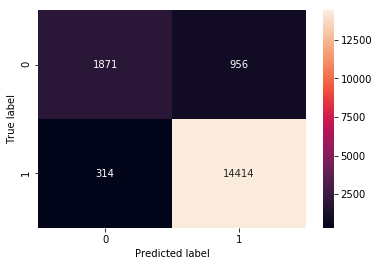

In [121]:
clf = LogisticRegression(C=1, penalty ='l1');
clf.fit(train_tfidf, y_train)
#w = clf.coef_
#print("Sparsity:",np.count_nonzero(w))

#conf_matrix = confusion_matrix(y_test,pred)
cclf=clf.predict(test_tfidf)
pred_test = clf.predict_proba(test_tfidf)[:,1]
#print('alpha value = ',1)
#acc = accuracy_score(y_test,pred_test)*100
#print("Accuracy",acc)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Area under the ROC curve : %f 0.9643644441250631
[[ 1694  1133]
 [  192 14536]]


Text(0.5, 15.0, 'Predicted label')

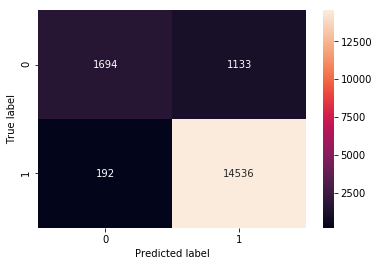

In [122]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=1, penalty ='l2');
clf.fit(train_tfidf, y_train)
#w = clf.coef_
#print("Sparsity:",np.count_nonzero(w))

#conf_matrix = confusion_matrix(y_test,pred)
cclf=clf.predict(test_tfidf)
pred_test = clf.predict_proba(test_tfidf)[:,1]
#print('alpha value = ',1)
#acc = accuracy_score(y_test,pred_test)*100
#print("Accuracy",acc)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [123]:
# Please write all the code with proper documentation
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    print("Positive coefficients:",feature_names[top_positive_coefficients])
    print("Negative coefficients:",feature_names[top_negative_coefficients])
    
plot_coefficients(clf, tfidf_vect.get_feature_names(), top_features=20)

Positive coefficients: ['without' 'yummy' 'definitely' 'tasty' 'awesome' 'happy' 'easy'
 'favorite' 'amazing' 'not disappointed' 'wonderful' 'nice' 'excellent'
 'loves' 'love' 'perfect' 'good' 'delicious' 'best' 'great']
Negative coefficients: ['disappointed' 'not' 'worst' 'disappointing' 'not worth' 'terrible'
 'not good' 'awful' 'horrible' 'not recommend' 'not buy' 'disappointment'
 'unfortunately' 'bad' 'threw' 'stale' 'weak' 'return' 'money' 'bland']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [133]:
# Please write all the code with proper documentation
#https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
#Applying GridSearch to find the best hyperparameter C

tuned_parameter = [{'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]}]
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
grid = GridSearchCV(estimator=clf, param_grid = tuned_parameter ,scoring = scoring, refit = 'AUC')
grid.fit(sent_vectors, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.score(sent_vectors_test,y_test))
results = grid.cv_results_
#print(results)
#print(grid.confusion_matrix)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000,
                                10000]}],
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, verbose=0)
0.9080226568236914
LogisticRegression(C=100, class_weight=None, d

Area under the ROC curve : %f 0.9044572329329176
[[ 1396  1431]
 [  515 14213]]


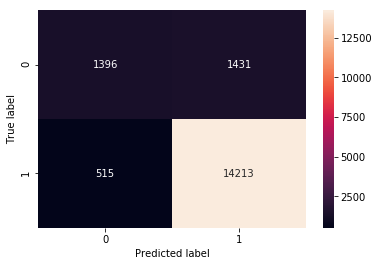

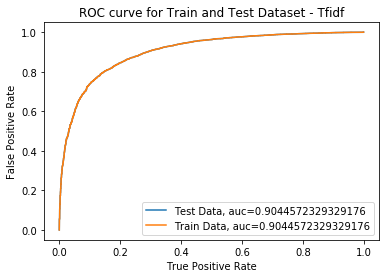

In [136]:
clf = LogisticRegression(C=100, penalty ='l1');
clf.fit(sent_vectors, y_train)
#w = clf.coef_
#print("Sparsity:",np.count_nonzero(w))

#conf_matrix = confusion_matrix(y_test,pred)
cclf=clf.predict(sent_vectors_test)
pred_test = clf.predict_proba(sent_vectors_test)[:,1]
#print('alpha value = ',1)
#acc = accuracy_score(y_test,pred_test)*100
#print("Accuracy",acc)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Plot ROC Curve
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test))
fpr, tpr, thresh = roc_curve(y_test, pred_test)
roc_auc_cv = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv))
plt.title('ROC curve for Train and Test Dataset - Tfidf')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Area under the ROC curve : %f 0.9044485385455336
[[ 1396  1431]
 [  515 14213]]


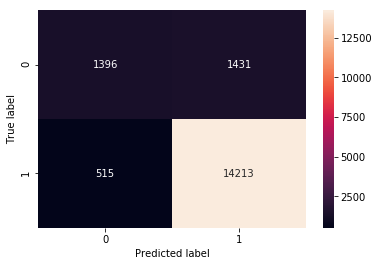

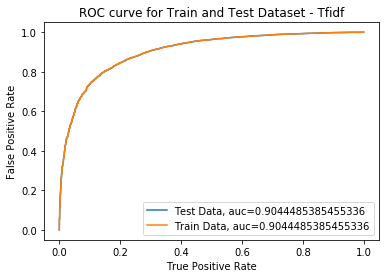

In [137]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=100, penalty ='l2');
clf.fit(sent_vectors, y_train)
#w = clf.coef_
#print("Sparsity:",np.count_nonzero(w))

#conf_matrix = confusion_matrix(y_test,pred)
cclf=clf.predict(sent_vectors_test)
pred_test = clf.predict_proba(sent_vectors_test)[:,1]
#print('alpha value = ',1)
#acc = accuracy_score(y_test,pred_test)*100
#print("Accuracy",acc)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Plot ROC Curve
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test))
fpr, tpr, thresh = roc_curve(y_test, pred_test)
roc_auc_cv = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv))
plt.title('ROC curve for Train and Test Dataset - Tfidf')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)

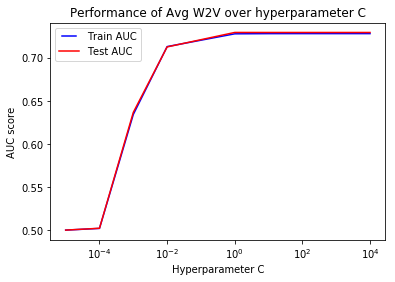

In [142]:
C = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]
train_results = []
test_results = []
for i in C:
    clf = LogisticRegression(C=i)
    clf.fit(sent_vectors, y_train)
    train_pred = clf.predict(sent_vectors)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = clf.predict(sent_vectors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
ax = plt.gca()
ax.set_xscale('log')
line1, = ax.plot(C, train_results, 'b', label="Train AUC")
line2, = ax.plot(C, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title("Performance of Avg W2V over hyperparameter C")
plt.ylabel('AUC score')
plt.xlabel('Hyperparameter C')
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [143]:
#https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
#Applying GridSearch to find the best hyperparameter C

tuned_parameter = [{'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]}]
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
grid = GridSearchCV(estimator=clf, param_grid = tuned_parameter ,scoring = scoring, refit = 'AUC')
grid.fit(tfidf_sent_vectors, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.score(tfidf_sent_vectors_test,y_test))
results = grid.cv_results_
#print(results)
#print(grid.confusion_matrix)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000,
                                10000]}],
             pre_dispatch='2*n_jobs', refit='AUC', return_train_score=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, verbose=0)
0.8841530041400345
LogisticRegression(C=1, class_weight=None, dua

Area under the ROC curve : %f 0.8799236652001813
[[ 1121  1706]
 [  458 14270]]


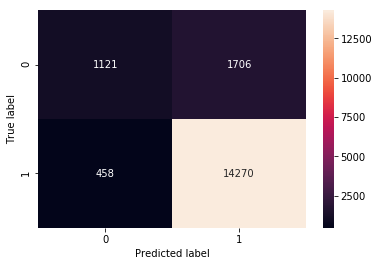

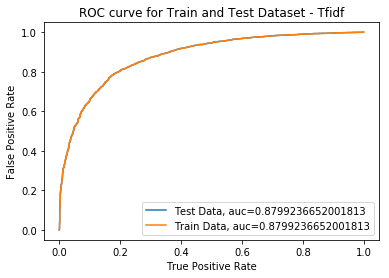

In [144]:
clf = LogisticRegression(C=1, penalty ='l1');
clf.fit(tfidf_sent_vectors, y_train)
#w = clf.coef_
#print("Sparsity:",np.count_nonzero(w))

#conf_matrix = confusion_matrix(y_test,pred)
cclf=clf.predict(tfidf_sent_vectors_test)
pred_test = clf.predict_proba(tfidf_sent_vectors_test)[:,1]
#print('alpha value = ',1)
#acc = accuracy_score(y_test,pred_test)*100
#print("Accuracy",acc)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Plot ROC Curve
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test))
fpr, tpr, thresh = roc_curve(y_test, pred_test)
roc_auc_cv = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv))
plt.title('ROC curve for Train and Test Dataset - Tfidf')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Area under the ROC curve : %f 0.8799151389363105
[[ 1120  1707]
 [  458 14270]]


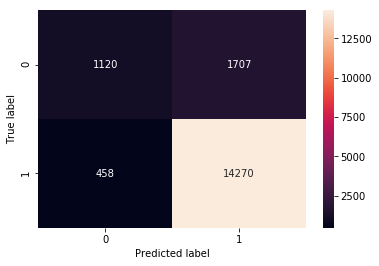

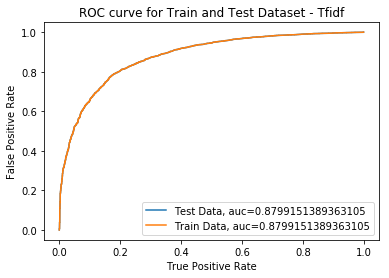

In [145]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=1, penalty ='l2');
clf.fit(tfidf_sent_vectors, y_train)
#w = clf.coef_
#print("Sparsity:",np.count_nonzero(w))

#conf_matrix = confusion_matrix(y_test,pred)
cclf=clf.predict(tfidf_sent_vectors_test)
pred_test = clf.predict_proba(tfidf_sent_vectors_test)[:,1]
#print('alpha value = ',1)
#acc = accuracy_score(y_test,pred_test)*100
#print("Accuracy",acc)
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Plot ROC Curve
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test))
fpr, tpr, thresh = roc_curve(y_test, pred_test)
roc_auc_cv = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv))
plt.title('ROC curve for Train and Test Dataset - Tfidf')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)


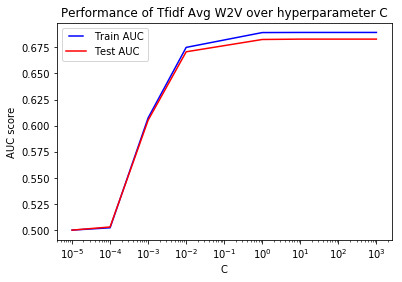

In [149]:
#Performance of Tfidf Avg w2v over hyperparameter C
C = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
train_results = []
test_results = []
for i in C:
    clf = LogisticRegression(C=i)
    clf.fit(tfidf_sent_vectors, y_train)
    train_pred = clf.predict(tfidf_sent_vectors)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = clf.predict(tfidf_sent_vectors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
ax = plt.gca()
ax.set_xscale('log')
line1, = ax.plot(C, train_results, 'b', label="Train AUC")
line2, = ax.plot(C, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title("Performance of Tfidf Avg W2V over hyperparameter C")
plt.ylabel('AUC score')
plt.xlabel('C')
plt.show()


# [6] Conclusions

In [151]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
table = PrettyTable(["model","C value","Test AUC"])
table.add_row(["LR using BoW", "1",0.934])
table.add_row(["LR using TFIDF","1",0.964])
table.add_row(["LR using AVG W2V","100",0.904])
table.add_row(["LR using TFIDF AVG W2V","1",0.8799])
print(table)

+------------------------+---------+----------+
|         model          | C value | Test AUC |
+------------------------+---------+----------+
|      LR using BoW      |    1    |  0.934   |
|     LR using TFIDF     |    1    |  0.964   |
|    LR using AVG W2V    |   100   |  0.904   |
| LR using TFIDF AVG W2V |    1    |  0.8799  |
+------------------------+---------+----------+


1. Logistic Regression is applied on Amazon food review dataset with four different vectorization techniques.
2. The hyperparameter C is tuned using GridSearchCV and the test results are predicted. 
3. Various C values are used to predict the sparsity in BoW with L1 regularizer. It is found that the sparsity(number of non zero vectors)decreases as C value decreases. L1 and L2 regularisations are used. 
4. Perturbation technique is applied to check for multicollinearity. 
5. From the above table, AUC score for BoW and TFIDF are better than the rest.